# SPEECH RECOGNITION PROJECT ON BEMBA LANGUAGE

## Preambles: Installations and imports of necessary tools

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install torchaudio
!pip install PyDrive
!pip install soundfile
# for clearing the verbose output
from IPython.display import clear_output
clear_output()

In [5]:
! git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [6]:
%cd /content/CPC_audio
!python setup.py develop
clear_output()

In [7]:
# importing all necessary pytorch tools for the project
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# import cpc encoder and decoder from the cpc model module
%cd /content/CPC_audio
from cpc.model import CPCEncoder, CPCAR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialization of necessary variables
LEARNING_RATE=2e-4
SIZE_WINDOW = 20480
BATCH_SIZE=8

/content/CPC_audio


In [9]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data
!ls checkpoint_data
clear_output()

In [10]:
##??cpc_model to check the model being used


## CPC model with ```CTC loss``` and ```Adam``` optimizer

In this part we will consider a fine-tuning with non-aligned phonemes. The model, the optimizer and the phone classifier will stay the same. However, we will replace our phone criterion with a [CTC loss](https://pytorch.org/docs/master/generated/torch.nn.CTCLoss.html). 

Since the phonemes are not aligned, there is no simple direct way to get the classification acuracy of a model. We write and test the three functions ```train_one_epoch_ctc```, ```validation_step_ctc``` and ```run_ctc``` as before but without considering the average acuracy of the model.

In [11]:
# Several functions that will be necessary to load the data later
def load_dataset(path_dataset, file_extension='.wav', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

In [12]:
class PhoneClassifier(torch.nn.Module):

  def __init__(self, input_dim : int, n_phones : int):
    super(PhoneClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, n_phones)

  def forward(self, x):
    return self.linear(x)

In [13]:
def train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader, optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs

  avg_loss/=n_items
  return avg_loss

In [14]:
def validation_step(cpc_model, phone_classifier, loss_criterion, data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

In [15]:
def run_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, data_loader_val, optimizer, n_epoch, verbose):
  tr_loss_ctc = []
  vl_loss_ctc = []
  for epoch in range(n_epoch):
    loss_train = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
    loss_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
    tr_loss_ctc.append(loss_train)
    vl_loss_ctc.append(loss_val)
    if verbose is True:
      print(f"Epoch [{epoch + 1}/{n_epoch}]:")
      print("------------")
      print("Train : - average loss - : {:.5f}".format(loss_train))   
      print("Valid : - average loss - : {:.5f}".format(loss_val))
      print()
  return tr_loss_ctc, vl_loss_ctc

## Load CPC pretrained model and dataset

In [16]:
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs

path_train_data_per = '/content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/train/'
path_val_data_per = '/content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/valid/'
path_test_data_per = '/content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/test/'
path_phone_data_per = '/content/drive/My Drive/AMMI/Speech Recognition/all_sessions.txt'

phone_labels, N_PHONES = parseSeqLabels(path_phone_data_per)
data_train_per, _ = findAllSeqs(path_train_data_per, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_per, data_train_per, phone_labels)
data_loader_train = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE, shuffle=True)

data_val_per, _ = findAllSeqs(path_val_data_per, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_per, data_val_per, phone_labels)
data_loader_val = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE, shuffle=True)

data_test_per, _ = findAllSeqs(path_test_data_per, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_per, data_test_per, phone_labels)
data_loader_val = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE, shuffle=True)

/content/CPC_audio


5it [00:02,  2.23it/s]


Saved cache file at /content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/train/_seqs_cache.txt


0it [00:00, ?it/s]

Loaded 291 sequences in 10.16 seconds
maxSizeSeq : 249018
maxSizePhone : 125
minSizePhone : 9
Total size dataset 0.6547205729166666 hours


4it [00:00,  4.17it/s]


Saved cache file at /content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/valid/_seqs_cache.txt


0it [00:00, ?it/s]

Loaded 146 sequences in 5.56 seconds
maxSizeSeq : 306735
maxSizePhone : 145
minSizePhone : 13
Total size dataset 0.35323807291666665 hours


13it [00:02,  5.17it/s]


Saved cache file at /content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/test/_seqs_cache.txt
Loaded 516 sequences in 17.95 seconds
maxSizeSeq : 275517
maxSizePhone : 120
minSizePhone : 8
Total size dataset 1.1086903819444445 hours


## Running the CTC model

In [17]:
# --- checking cpc with ctc loss --- #
from cpc.feature_loader import loadModel

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).to(device)

loss_ctc = nn.CTCLoss()
cpc_model = cpc_model.cuda()

parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
optimizer_frozen = optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

train_loss_ctc, valid_loss_ctc = run_ctc(cpc_model,phone_classifier,loss_ctc,data_loader_train,data_loader_val,optimizer_frozen, n_epoch=50,verbose=False)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [18]:
# ??cpc_model

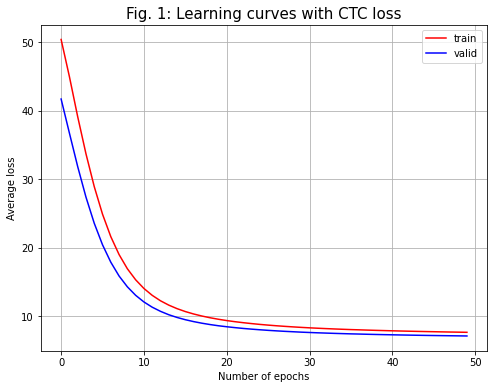

In [19]:
# --- Plotting the CPC model training learning curves --- #
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title('Fig. 1: Learning curves with CTC loss', fontsize=15)
plt.plot(train_loss_ctc, 'r', linewidth = 1.5, label='train')
plt.plot(valid_loss_ctc, 'b', linewidth = 1.5, label='valid')
#plt.axis([0, 50, 0, 50])
plt.xlabel('Number of epochs')
plt.ylabel('Average loss')
plt.grid(True)
plt.legend();

## Evaluation using CER

In [20]:
import numpy as np

def get_PER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1
  
  ### TODO compute the alignment

  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)

In [21]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_per(test_dataloader, cpc_model, phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 

  print("Starting the PER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
        phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        data_per = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]

        with Pool(bs) as p:
            poolData = p.starmap(get_PER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgPER /= nItems

  print(f"Average PER {avgPER}")
  return avgPER


In [22]:
# Load a dataset labelled with the letters of each sequence.
%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs

path_train_data_cer = '/content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/train'
path_val_data_cer = '/content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/valid'
path_test_data_cer = '/content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/test'

path_letter_data_cer = '/content/drive/My Drive/AMMI/Speech Recognition/all_sessions.txt'

letters_labels, N_LETTERS = parseSeqLabels(path_letter_data_cer)
data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)


data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)


data_test_cer, _ = findAllSeqs(path_test_data_cer, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_cer, data_test_cer, letters_labels)

data_loader_train_letters = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE, shuffle=True)
data_loader_val_letters = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE, shuffle=False)
data_loader_test_letters = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE, shuffle=False)

5it [00:00, 331.89it/s]

/content/CPC_audio


Saved cache file at /content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/train/_seqs_cache.txt


4it [00:00, 421.01it/s]

Loaded 291 sequences in 2.62 seconds
maxSizeSeq : 249018
maxSizePhone : 125
minSizePhone : 9
Total size dataset 0.6547205729166666 hours
Saved cache file at /content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/valid/_seqs_cache.txt



13it [00:00, 490.57it/s]

Loaded 146 sequences in 2.06 seconds
maxSizeSeq : 306735
maxSizePhone : 145
minSizePhone : 13
Total size dataset 0.35323807291666665 hours
Saved cache file at /content/drive/My Drive/AMMI/Speech Recognition/bemba_speech_dataset/test/_seqs_cache.txt


Loaded 516 sequences in 3.72 seconds
maxSizeSeq : 275517
maxSizePhone : 120
minSizePhone : 8
Total size dataset 1.1086903819444445 hours


In [23]:
# --- checking cpc with ctc loss --- #
character_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
optimizer_frozen = optim.Adam(list(character_classifier.parameters()), lr=LEARNING_RATE)

# --- running model --- #
train_loss_cer, valid_loss_cer = \
run_ctc(cpc_model,character_classifier,loss_ctc,data_loader_train_letters,data_loader_val_letters,optimizer_frozen, n_epoch=50,verbose=False)

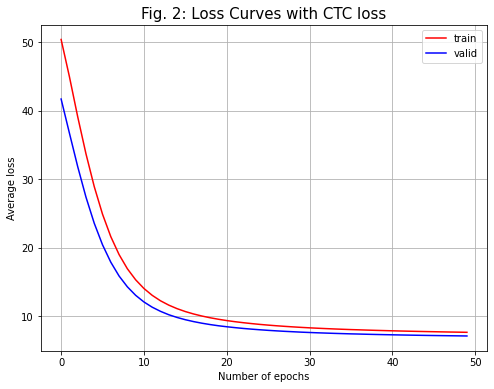

In [24]:
# --- Plotting the CPC model training learning curves --- #
plt.figure(figsize=(8, 6))
plt.title('Fig. 2: Loss Curves with CTC loss', fontsize=15)
plt.plot(train_loss_ctc, 'r', linewidth = 1.5, label='train')
plt.plot(valid_loss_ctc, 'b', linewidth = 1.5, label='valid')
#plt.axis([0, 50, 0, 50])
plt.xlabel('Number of epochs')
plt.ylabel('Average loss')
plt.grid(True)
plt.legend();

In [25]:
# --- Computing the Character Error Rate (CER) --- #
print('CER:', get_per(data_loader_test_letters,cpc_model,character_classifier))

N/A% (0 of 65) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (65 of 65) |########################| Elapsed Time: 0:25:57 Time:  0:25:57


Average PER 0.927255339983811
CER: 0.927255339983811
